# Лабораторная работа 2. Каналы связи

In [1]:
using Plots

## Бинарные каналы

### Задание 1

<img src="./src/1.1.png">

<strong>Решение:</strong> для определения скорости передачи данных сообщений и пропускной способности канала проведем моделирование.

Напишем функцию для моделирования идеального канала связи, передающего сообщение с помощью униполярного NRZ

In [2]:
function nrzU(msg,T)
    n = length(msg)
    dt = T/n
    time = 0:dt:T
    tp = length(time)
    signal = Vector{Int8}(undef,tp)
    signal[1] = 0
    for i in 2:tp 
        signal[i] = msg[i-1]
    end
    c = 1/dt # т. к. для двоичного кода установлено c = 1/τ
    # В сообщениях символы не равновероятны, поэтому для определения скорости передачи подсчитаем энтропию источника
    zerosN, onesN = count(i->(i==0),msg), count(i->(i==1),msg)
    p0, p1 = zerosN/n, onesN/n
    v = -1/dt*(p0*log2(p0)+p1*log2(p1))
    println("Пропускная способность канала: $c бит/с")
    println("Скорость передачи сообщения: $v бит/с")
    plot(1e3*time,signal,title="Сигнал",leg=false,
    seriestype=:steppre,xlabel="Время, мс",ylabel="Уровень, произв. ед.")
end;   

Сообщения и время трансляции

In [3]:
msg1::BitVector = [1,1,0,0,0,0,1,1,0,1]
msg2::BitVector = [1,0,1,1,1,1,0,0,1,1]
T = 20e-3;

Пропускная способность канала: 500.0 бит/с
Скорость передачи сообщения: 500.0 бит/с


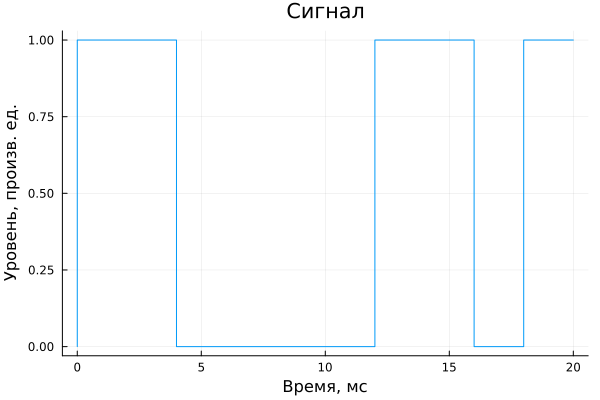

In [4]:
nrzU(msg1,T)

Пропускная способность канала: 500.0 бит/с
Скорость передачи сообщения: 440.64544961534637 бит/с


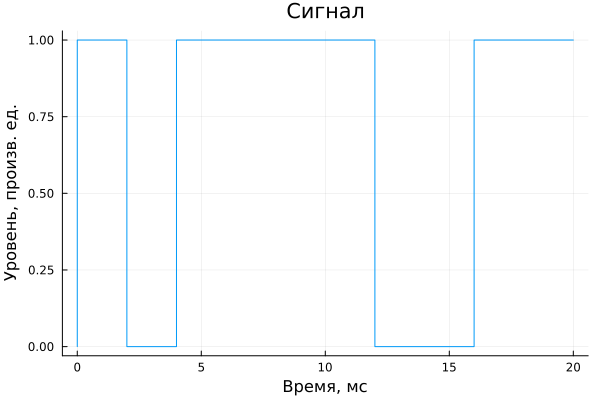

In [5]:
nrzU(msg2,T)

В общем случае скорость передачи данных по дискретному каналу связи без помех равна пропускной способности, а для сообщений одинаковой длины скорость передачи данных будет одинаковой. <strong>Тем не менее,</strong> в задаче не фигурирует напрямую длина сообщения, есть лишь содержание, поэтому <strong>предположим,</strong> что используется метод кодирования-декодирования, основанный на частоте символов в сообщении, а не просто последовательность битов. Так интереснее решать, а условию не противоречит. Для следующей задачи аналогично.

### Задание 2

<img src="./src/1.2.png">

<strong>Решение:</strong> пропускную способность канала связи с помехами можно выразить формулой $$C = L \max I(Y,X),$$ где $L$ - количество символов в единицу времени  и $\max I(Y,X)$ - максимальная полная взаимная информация, передаваемая одним сигналом.

В этой задаче полная средняя взаимная информация равна разности энтропии на приемнике и условной энтропии при передаче $I(Y,X)=H(Y)-H(Y/X)$. 
Введем специальную функцию $\eta(p)=-p\log_{2}{p}$ для упрощенного определения энтропии для бинарного алфавита по формуле Шеннона $H(X)=-\sum_{i=1}^2p_i{\log_{2}{p_i}}=-\sum_{i=1}^2{\eta(p_i)}$.

Введем специальную функцию с дополнительным определением в нуле (воспользовавшись пределом - на всякий случай и для графика):

In [6]:
η(p) = (p==0) ? 0 : -p*log2(p);

Определим энтропию на приемнике. Обозначим вероятности получения $0$ и $1$ на приемнике через $r$ и $1-r$, генерации на источнике через $p$ и $1-p$, а вероятность инвертирования бита через $\mu$ и $\mu-1$. Получим выражение для полной взаимной информации на сигнал $I(Y,X)=(\eta(r)+\eta(1-r))-(\eta(\mu)+\eta(1-\mu))$. Так как $\mu$ в задаче нам известно, для максимизации выражения необходимо найти максимальное значение энтропии приемника.

Для определения случая, в котором информация максимальна, исследуем первое слагаемое.

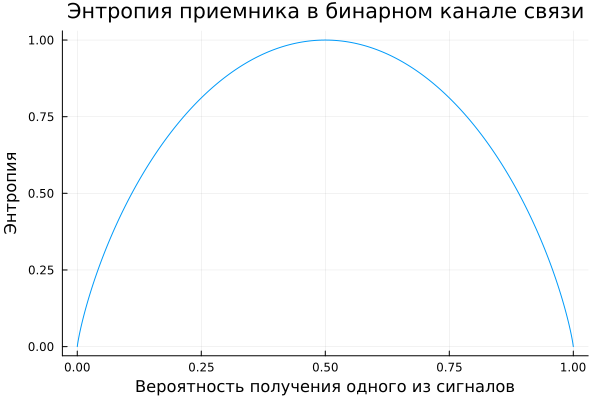

In [7]:
testProbs = 0:1e-3:1
plot(testProbs, (η.(testProbs)+η.(1 .- testProbs)), leg=false,
title="Энтропия приемника в бинарном канале связи", xlabel="Вероятность получения одного из сигналов", ylabel="Энтропия")

График доказывает, что информация максимальна при энтропии приемника, равной 1 и равновероятном получении сигналов двоичного кода (по 0.5). Таким образом, можем переписать выражение для максимальной информации на сигнал: $\max I(Y,X) = 1-(\eta(\mu)+\eta(1-\mu)$. 

Напишем функцию пропускной способности от количества битов в единицу времени, вероятности инвертирования бита при передаче:

In [8]:
C(L,μ) = L*(1-(η(μ)+η(1-μ)));

Теперь необходимо оценить скорость передачи сообщения. В отличие от пропускной способности канала, она будет зависеть и от содержания сообщения (с учетом оговорки о кодировании выше) - символы могут быть неравновероятны. Напишем функцию оценки скорости передачи сообщения с учетом содержания, рассчитывая энтропию приемника с помощью теоремы умножения вероятности и полной вероятности:

In [9]:
function v(L,msg,μ)
    # Вероятности нулей и единиц в сообщении
    n = length(msg)
    zerosN, onesN = count(i->(i==0),msg), count(i->(i==1),msg)
    pX0, pX1 = zerosN/n, onesN/n
    # Учет вероятности инвертирования бита
    p01, p10 = μ, μ
    p00, p11 = 1-μ, 1-μ
    # Расчет вероятностей получения символов
    pY0 = pX0*p00+pX1*p10
    pY1 = pX1*p11+pX0*p01
    # Расчет информации по энтропии приемника и ненадежности канала 
    I = (η(pY0)+η(pY1))-(η(μ)+η(1-μ))
    return L*I
end;

Исходные параметры: сообщение, время передачи, вероятность помехи для двух случаев

In [10]:
msg::BitVector = [1,1,0,0,1,1,0,1,0,1]
T = 0.1
μ = (1e-2, 1e-3);

Расчет количества элементарных сигналов в секунду

In [11]:
L = length(msg)/T;

Проведем расчет ответов для обоих случаев

In [12]:
for i in μ
    println("При вероятности ошибки ",i," пропускная способность канала равна ",C(L,i),
    " бит/с; скорость передачи сообщения равна ",v(L,msg,i)," бит/с")
end

При вероятности ошибки 0.01 пропускная способность канала равна 91.92068641040888 бит/с; скорость передачи сообщения равна 89.13153677417797 бит/с
При вероятности ошибки 0.001 пропускная способность канала равна 98.85922422625389 бит/с; скорость передачи сообщения равна 95.96597089994403 бит/с


Оценим влияние изменения вероятности помехи на пропускную способность и скорость передачи данного сообщения

In [13]:
println("При уменьшении вероятности помехи в ",μ[1]/μ[2],
    " раз пропускная способность канала увеличится на ", round((C(L,μ[2])/C(L,μ[1])-1)*100,digits=2),
    "%, скорость передачи увеличится на ",round((v(L,msg,μ[2])/v(L,msg,μ[1])-1)*100,digits=2),"%")

При уменьшении вероятности помехи в 10.0 раз пропускная способность канала увеличится на 7.55%, скорость передачи увеличится на 7.67%


## Непрерывные каналы

### Задание 1

<img src="./src/2.1.png">

<strong>Решение:</strong> для расчета пропускной способности канала необходимо обратиться к теореме Шеннона: $$C = \Delta F\log_{2}{(1+\frac{S}{N})},$$ где $C$ - пропускная способность канала, $\Delta F$ - полоса пропускания канала, $S$ и $N$ - мощности сигнала и шума соответственно.

Предположим, что на погрешность измерения влияет только шум, причем имеющий гауссово распределение в полосе пропускания, а значение сигнала постоянно. С этими допущениями для средних значений мощности сигнала и шума можем переписать теорему Шеннона следующим образом: $$C = \Delta F\log_{2}{(1+\frac{A_{сигнал}^2}{\sigma^2})},$$ где $\sigma^2$ - дисперсия шумового сигнала. В таком случае, для решения задачи нам необходимо оценить дисперсию для $[9.95,10.05]$.

In [14]:
sArr = 9.95:0.01:10.05
sqE = Vector{Float64}(undef,length(sArr))
for (i,v) in enumerate(sArr)
    sqE[i] = (v-10.0)^2
end
sigma = sum(sqE)/length(sqE);

И ввести функцию для итогового расчета

In [15]:
C(dF,As,sigma) = dF*log2(1+(As^2)/sigma)
dF = 100e6
As = 10
print("Пропускная способность канала равна ",C(dF,As,sigma)," бит/с")

Пропускная способность канала равна 1.66096549013151e9 бит/с

Так, пропускная способность данного канала связи равна <strong>1,66 Гбит/с</strong>.

### Задание 2

<img src="./src/2.2.png">

В отличие от предыдущего задания, нет необходимости рассматривать распределение шума, что дает право оценить абсолютную погрешность как половину амплитуды шума. Определим ее: $$SNR_{dB}=20\log_{10}{(\frac{A_{сигнал}}{A_{шум}})} \Rightarrow A_{шум}=\frac{A_{сигнал}}{10^{\frac{SNR_{dB}}{20}}}$$

Исходные параметры: SNR в дБ, амплитуда сигнала

In [16]:
snr = 30
As = 5;

Расчет

In [17]:
An = As/(10^(snr/20));

<strong>Ответ</strong>

In [18]:
print("Абсолютная погрешность при измерении составит ",round(An,digits=2)/2," В")

Абсолютная погрешность при измерении составит 0.08 В

### Задание 3

<img src="./src/2.3.png">

По аналогии с предыдущими задачами, определим абсолютную погрешность амплитудой шума. Тогда, чтобы относительная погрешность измерения не превышала 1%, необходимо $A_{шум}\leq0.01A_{сигнал}$. Тогда запишем теорему Шеннона: $$C = \Delta F\log_{2}{(1+(\frac{A_{сигнал}}{A_{шум}})^2)} \Rightarrow C = \Delta F\log_{2}{(1+100^2)} \Rightarrow C = \Delta F\log_{2}{(10001)}$$

In [19]:
dF = 50e3
println("Пропускная способность канала составит ",dF*log2(10001)," бит/с")

Пропускная способность канала составит 664392.8320920273 бит/с


Так, пропускная способность канала связи <strong>664.39 Кбит/с</strong>.

### Задание 4

<img src="./src/2.4.png">

Предположим, что осуществляем передачу по барьеру Найквиста. В таком случае скорость передачи сигналов будет ограничена только полосой частот и скоростью модуляции. Таким образом, можем найти максимальную скорость передачи данных по этому каналу, умножив скорость модуляции на ширину полосы пропускания. 

In [20]:
df = 10e3
vMod = log2(32)
trS = df*vMod

50000.0

Так, скорость передачи данных по каналу составит <strong>50 Кбит/с</strong>